# Problemas de corazón
### Autor: Mario Fernández Simón

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#!pip install apafib --upgrade --user --quiet

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from yellowbrick.target.feature_correlation import feature_correlation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn import set_config
import warnings

from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from apafib import load_heart_failure

set_config(display='text')
warnings.filterwarnings('ignore')

In [3]:
# funcion para mostrar resultados
def save_results(clf, X_train, y_train, X_test, y_test, nclf, df):
    df.loc[nclf,'train acc'] = clf.bestscore if hasattr(clf, 'bestscore') else np.mean(cross_val_score(clf, X_train, y_train, cv=10))
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (W)'] = precision_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'recall score (W)'] = recall_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='weighted')
    return df

results_df = pd.DataFrame()

## Apartado A

Primero cargaremos los datos, los visualizaremos brevemente observando sobretodo las relaciones que existen entre variables y haremos los ajustes que creamos pertinentes.

In [4]:
data = load_heart_failure()
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Con solo un primer vistazo ya se puede observar como existen variables discretas como "time" y otras continuas como "serum_creatinine". Además, encontramos algunas categoricas como "sex".

In [5]:
data.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


Pese que al visualizar los datos ya parecía que no había valores perdidos, lo comprobaremos explícitamente.

In [6]:
data.isna().sum().sort_values(ascending=False)

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [7]:
# Separamos conjunto de datos en las variables y la variable objetivo
variables = data[data.columns[:-1]]
variableObj = data['DEATH_EVENT']

A continuación, calculamos la correlación que existe entre las variables.

(<Figure size 900x900 with 1 Axes>, <Axes: >)

<Axes: >

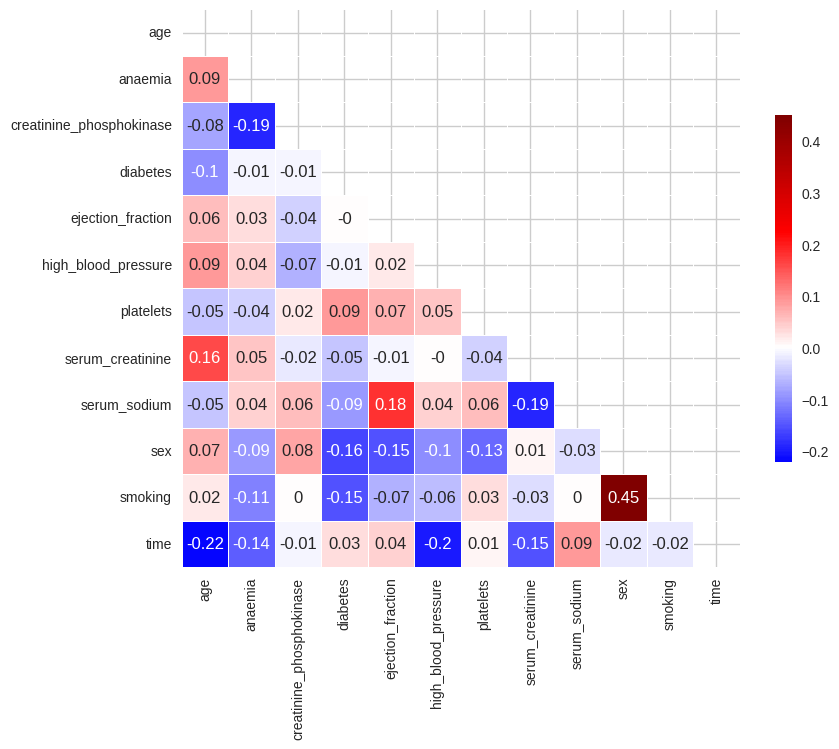

In [8]:
variablesFrame = pd.DataFrame(variables)
correlacion = variablesFrame.corr().round(2)
mask = np.triu(np.ones_like(correlacion, dtype=bool))
plt.subplots(figsize=(9, 9))
sns.heatmap(correlacion, mask=mask, cmap='seismic', annot = True, square=True, center=0, linewidths = .5, cbar_kws={"shrink": .5})

Vemos como realaciones directas fuertes solo existe "sex" con "smoking", relación la cual no nos aporta nada. Por otro lado, si que se observa como "sex" esta relacionado con las diferentes medidas que se obtienen de la sangre o enfermedades. Exactamente lo mismo pasa con "ejection_fraction", lo cual tiene sentido porque esta indica la cantidad de sangre que expulsa el corazón. 

<Figure size 800x800 with 0 Axes>

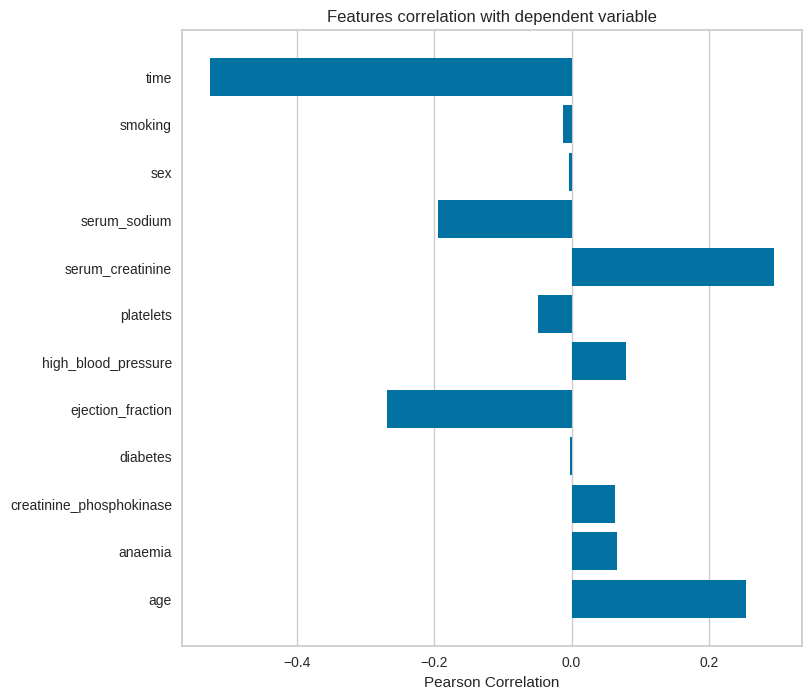

In [9]:
plt.figure(figsize=(8, 8))
corre = feature_correlation(variablesFrame, variableObj, labels=list(variablesFrame.columns),method='pearson')

Con esta gráfica ya podemos empezar a entender mejor como se comportan las variables con la variable objetivo. Por ejemplo, podemos relacionar que cuanto más tiempo pasa en observación el paciente menos oportunidades tendra de sufrir un "DEATH_EVENT". Otra conclusión, es que cuanta mas edad tenga el paciente más probabilidad tendrá de superar el incidente como es lógico. Por último, vemos como tener o la falta de algunas substancias en la sangre también tiene relevancia.

A continuación, proyectaremos los histogramas con todas las variables pese a que tener las categoricas como "sex" no tenga sentido (como son pocas no ha sido necesario hacer un filtrado).

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'anaemia'}>,
        <Axes: title={'center': 'creatinine_phosphokinase'}>],
       [<Axes: title={'center': 'diabetes'}>,
        <Axes: title={'center': 'ejection_fraction'}>,
        <Axes: title={'center': 'high_blood_pressure'}>],
       [<Axes: title={'center': 'platelets'}>,
        <Axes: title={'center': 'serum_creatinine'}>,
        <Axes: title={'center': 'serum_sodium'}>],
       [<Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'smoking'}>,
        <Axes: title={'center': 'time'}>]], dtype=object)

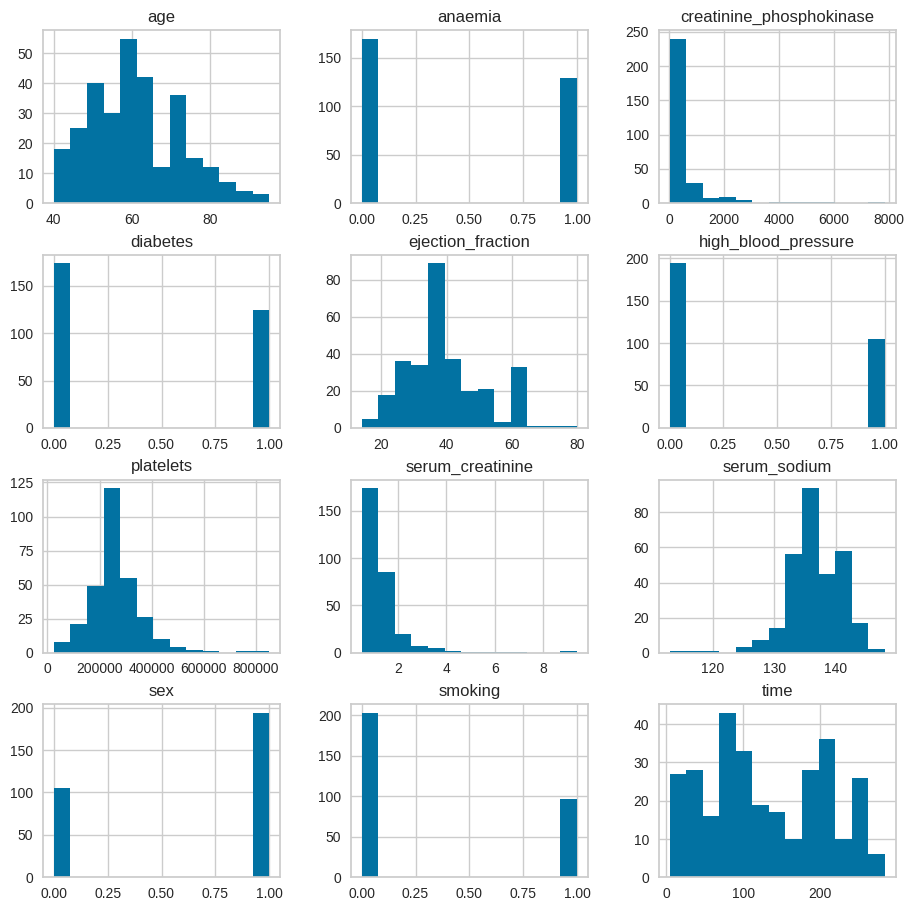

In [10]:
variables.hist(bins = 13, figsize=(11, 11))

Vemos como algunas no son del todo Gaussianas y por eso dividiremos nuestras varaibles en 2 sets. El primero estaran todas las variables sin modificar y en el segundo todas aquellas que se desvíen de la gaussianidad se les aplicara un logaritmo. 

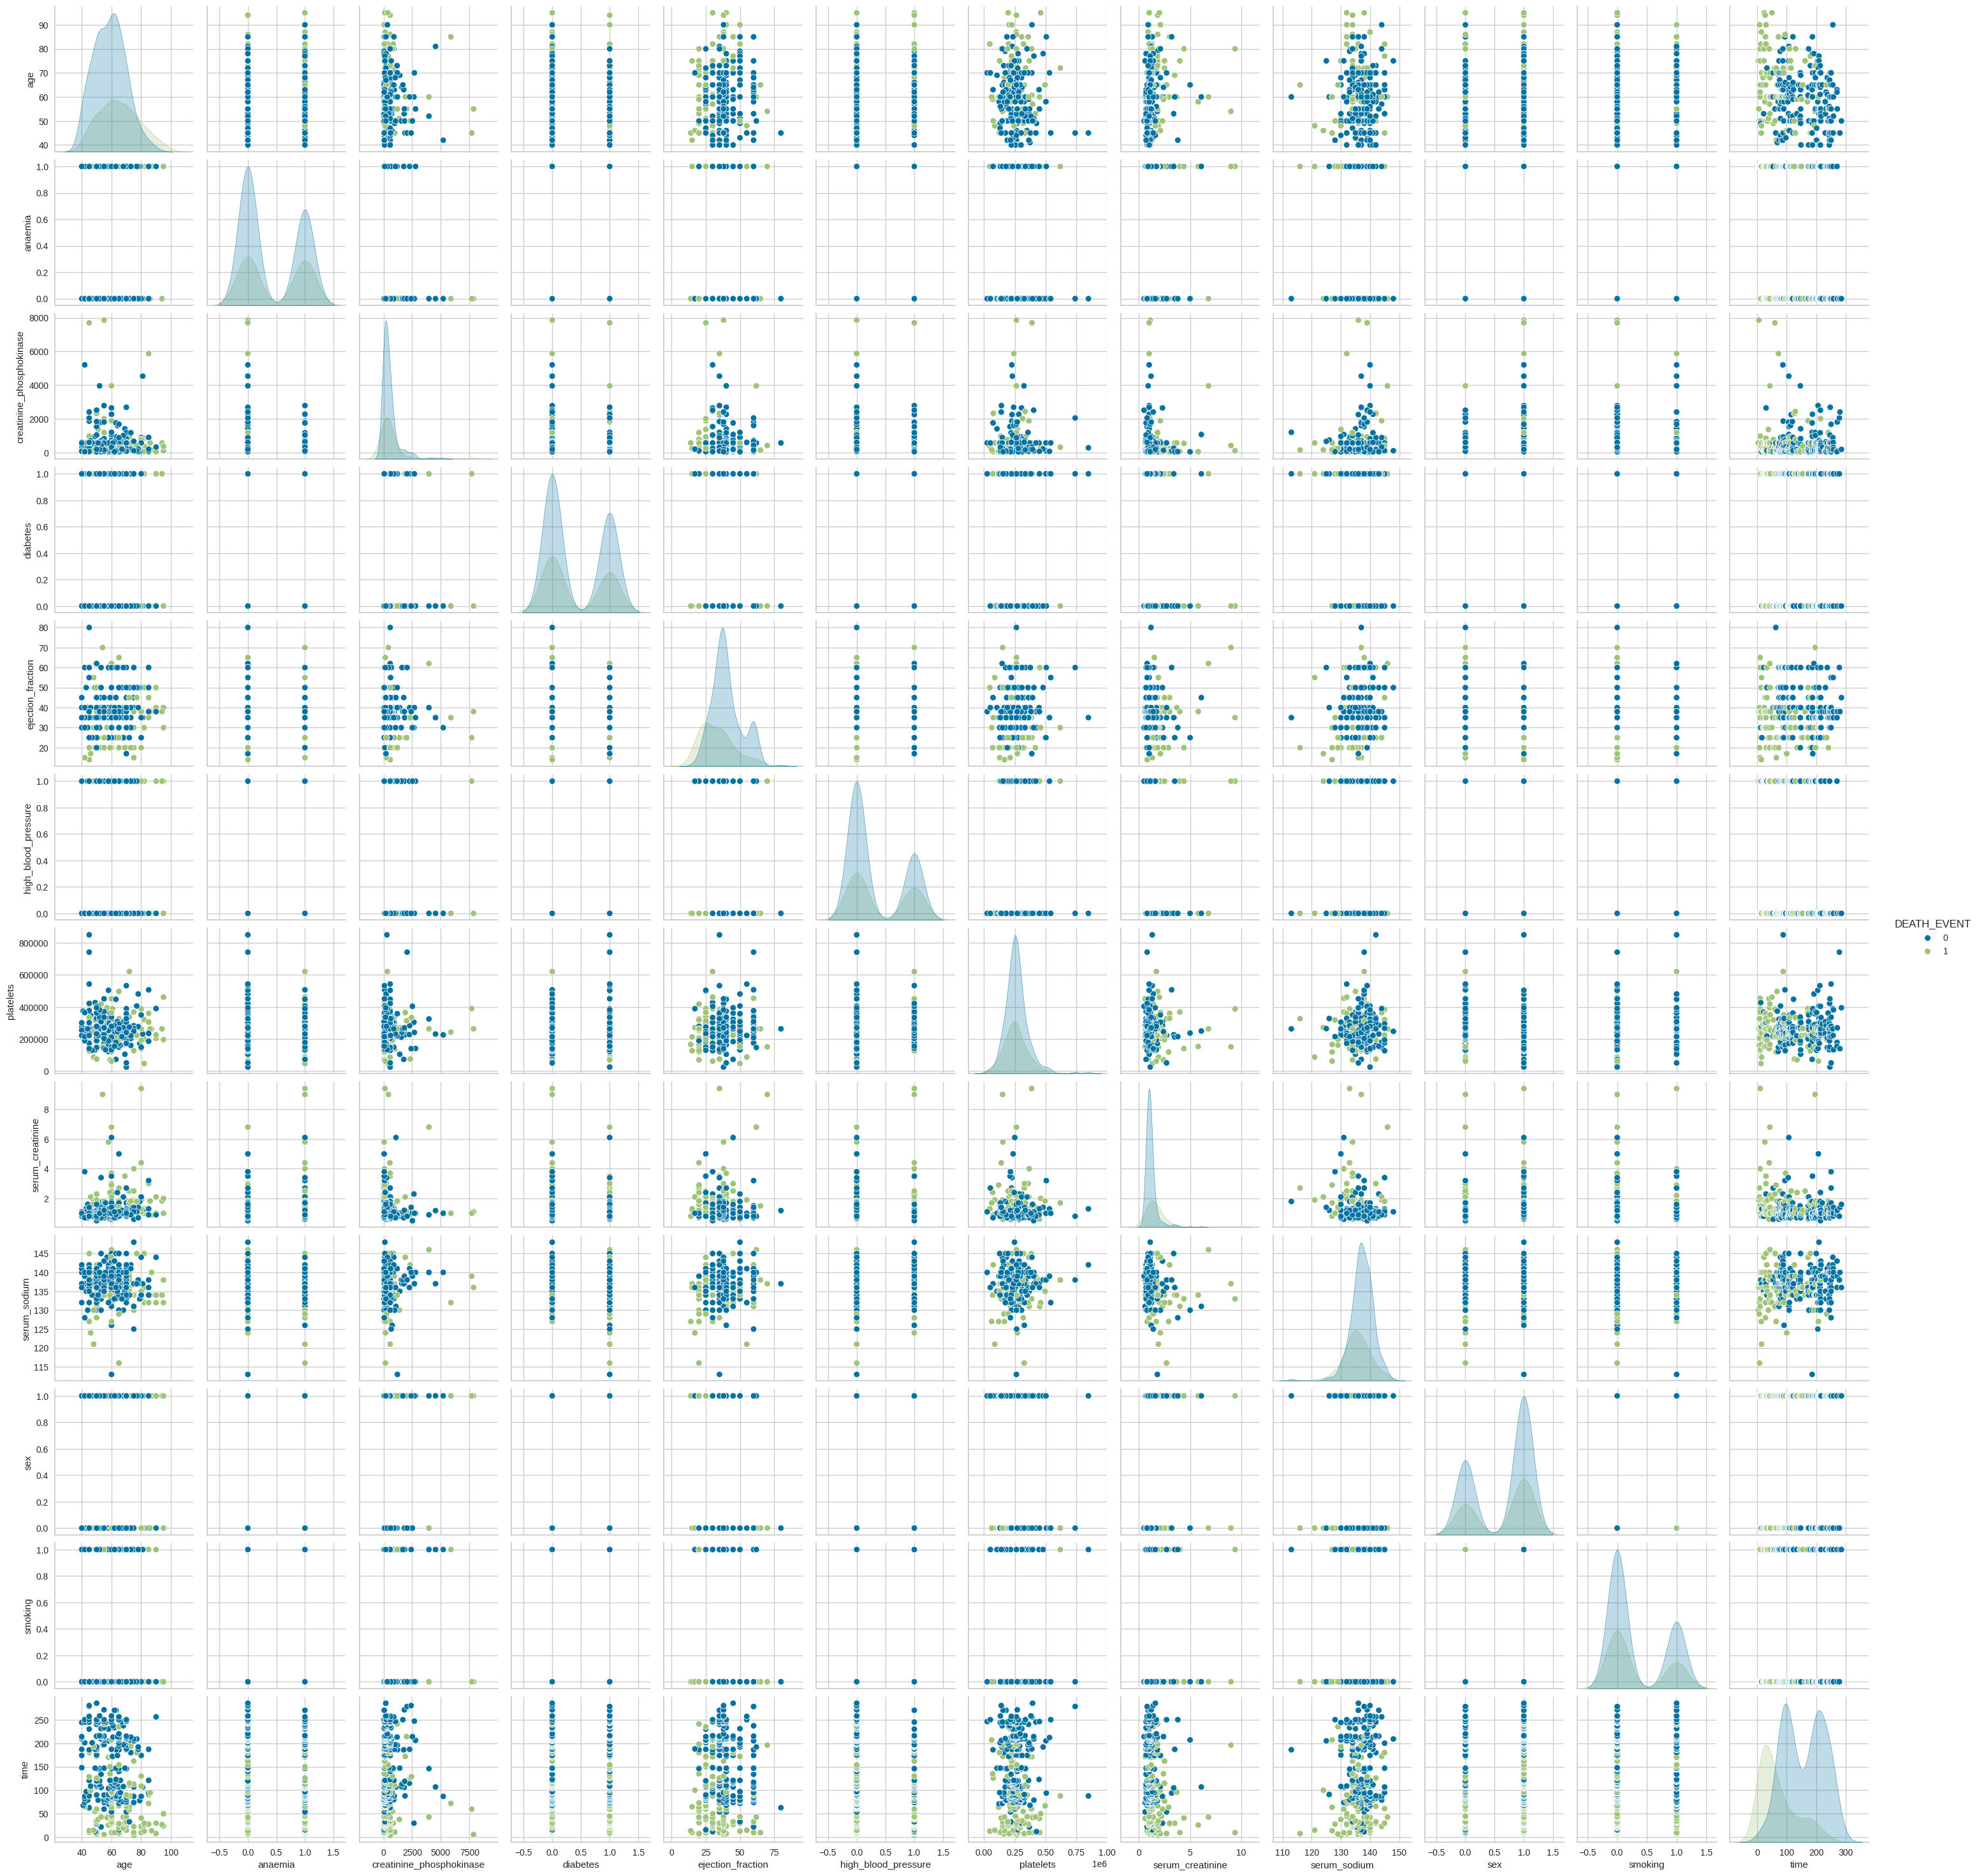

In [11]:
sns.pairplot(data,  hue='DEATH_EVENT')

También, hemos visualizado como se comportan las variables segun la variable objetivo. Cosa a destacar de la anterior gráfica seria que la variable time tiene 2 picos para los "Vivos" y 1 para los "Muertos", lo cual es lógico ya que al morir se deja de hacer el seguimiento. 

De los histogramas podemos ver como las varaibles que no siguen una distribución guassiana son: "creatinine_phosphokinase", "serum_creatinine", "platelets" y "ejection_fraction". Tambien vemos que "serum_sodium" no está al límite pero finalmente la consideraremos gaussiana. 

array([[<Axes: title={'center': 'creatinine_phosphokinase'}>,
        <Axes: title={'center': 'ejection_fraction'}>],
       [<Axes: title={'center': 'serum_creatinine'}>,
        <Axes: title={'center': 'platelets'}>],
       [<Axes: title={'center': 'time'}>, <Axes: >]], dtype=object)

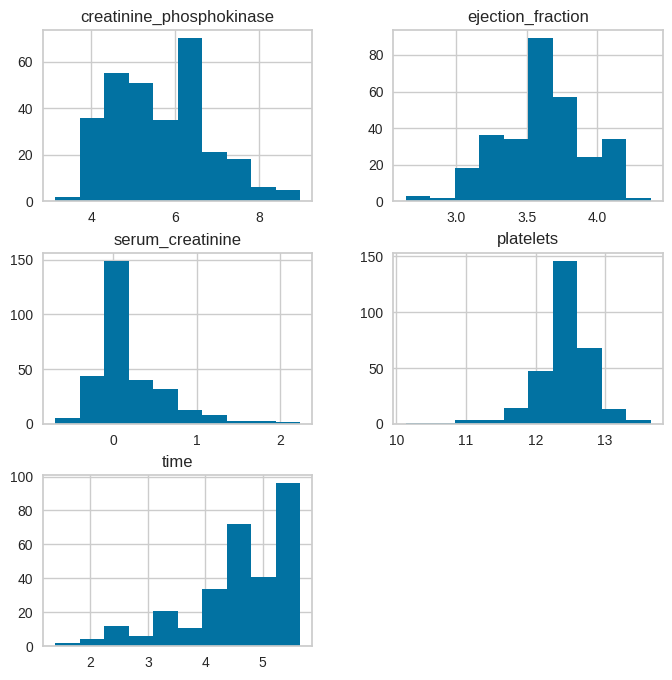

In [12]:
variablesNoGaus = variablesFrame[['creatinine_phosphokinase', 'ejection_fraction', 'serum_creatinine', 'platelets', 'time']]
variablesNoGausLog = np.log(variablesNoGaus)
variablesNoGausLog.hist(bins = 10, figsize=(8, 8))

In [13]:
# Creamos 2 grupos con los que trabajar
gaussVariables = variablesFrame.copy()
gaussVariables[['creatinine_phosphokinase', 'ejection_fraction', 'serum_creatinine', 'platelets', 'time']] = variablesNoGausLog

Hacemos la división de los datos como se indica en el enunciado (70/30)

In [14]:
train_varsNorm, test_varsNorm, y_train, y_test = train_test_split(variablesFrame, variableObj, test_size=0.3, random_state=42, stratify=variableObj)
train_varsNormGau, test_varsNormGau, y_trainGau, y_testGau = train_test_split(gaussVariables, variableObj, test_size=0.3, random_state=42, stratify=variableObj)

Normalizamos los 2 grupos de datos

In [15]:
scaler = StandardScaler()

# Normales
train_varsNorm[train_varsNorm.columns] = scaler.fit_transform(train_varsNorm[train_varsNorm.columns])
test_varsNorm[test_varsNorm.columns] = scaler.transform(test_varsNorm[test_varsNorm.columns])

# Gausianas
train_varsNormGau[train_varsNormGau.columns] = scaler.fit_transform(train_varsNormGau[train_varsNormGau.columns])
test_varsNormGau[test_varsNormGau.columns] = scaler.transform(test_varsNormGau[test_varsNormGau.columns])


## Apartado b: Naive Bayes

En este apartado, aplicaremos un modelo de Naive Bayes y evaluaremos la calidad de los modelos con los 2 grupos de datos.

Sobretodo, nos fijaremos en la precision (instancias positivas que fueron correctamente clasificadas con respecto a las clasificadas positivamente por el modelo), en el recall (instancias positivas que fueron correctamente clasificadas con respecto a las positivamente reales) y en el f1-score (combinación de precision y recall).

In [16]:
# Grupo sin aplicar logaritmo
gnb = GaussianNB()
print("CrossValScore:", np.mean(cross_val_score(gnb,train_varsNorm,y_train,cv=10)))
gnb_model = GaussianNB().fit(train_varsNorm, y_train)

print(classification_report(gnb_model.predict(test_varsNorm), y_test,target_names=['Vivo', 'Muerto']))
results_df = save_results(gnb_model, train_varsNorm, y_train, test_varsNorm, y_test, 'Naive Bayes', results_df)

CrossValScore: 0.7614285714285715
              precision    recall  f1-score   support

        Vivo       0.89      0.76      0.82        71
      Muerto       0.41      0.63      0.50        19

    accuracy                           0.73        90
   macro avg       0.65      0.70      0.66        90
weighted avg       0.79      0.73      0.75        90



Vemos como obtenemos una buena precision, recall y f1-score para saber los 'Vivos' pero no tan buena para los 'Muertos'. Continuamos valorando si es un buen modelo. Además la validación cruzada no es muy buena.

<Figure size 800x800 with 0 Axes>

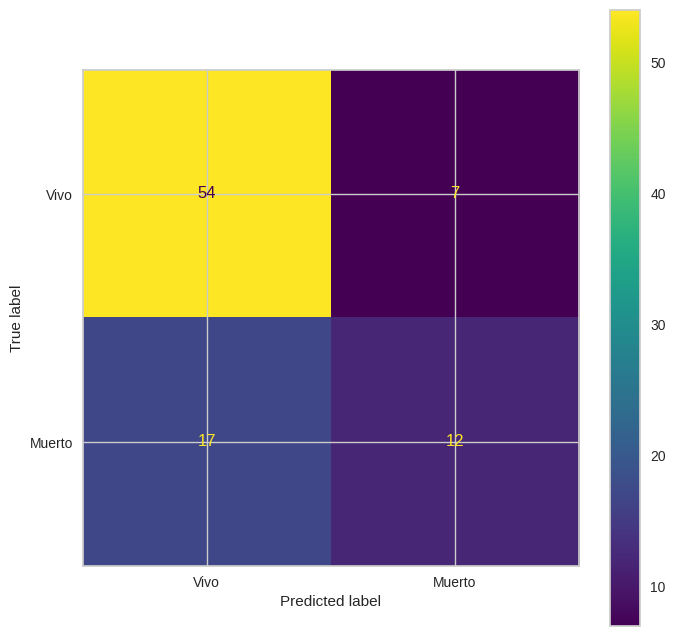

In [17]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(gnb_model, test_varsNorm,y_test, display_labels=['Vivo', 'Muerto'], ax=plt.subplot())

La matriz de confusión nos muestra muy claramente las carencias que tiene el modelo, el cual vemos como tiene bastantes casos de predecir que esta vivo y realmente no, lo cual puede ser preocupante en la vida real. Se prefiere que te diga que mueres y después realemente no es así que al contrario. 

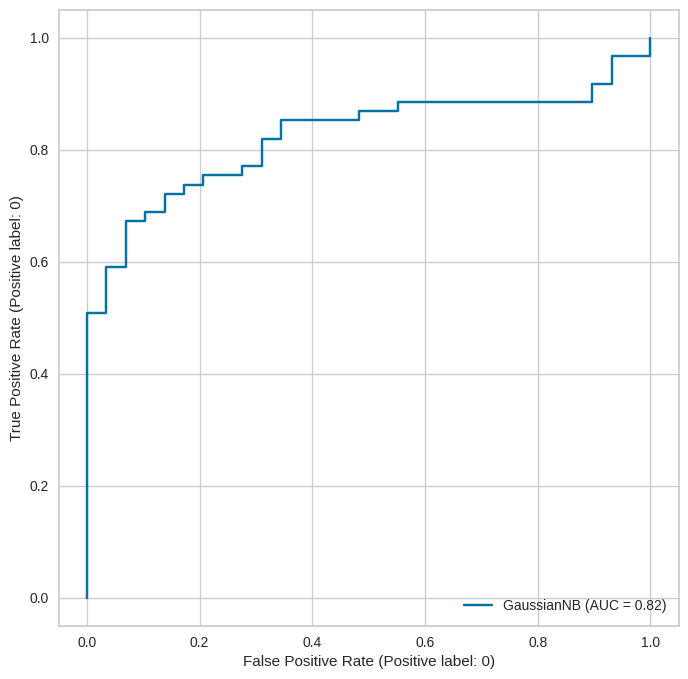

In [18]:
plt.figure(figsize=(8,8))
RocCurveDisplay.from_estimator(gnb_model, test_varsNorm,y_test, pos_label=0, ax=plt.subplot())

Para intentar mejorar el modelo buscaremos el lindar más adecuado. Si vemos la curba, observamos que un valor optimo seria tener un 80% de true positive para un 30% de false positive o, tambien se podría escoger, un 70% de true positive para un 10% de false positive.

In [19]:
y_prob = gnb_model.predict_proba(test_varsNorm)[:, 1]

thresholds = np.arange(0, 1.1, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred_thresholded = (y_prob > threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresholded))
best_threshold = thresholds[np.argmax(f1_scores)]

y_pred_best_threshold = (y_prob > best_threshold).astype(int)

print(f"Encert con lindar {best_threshold}: {accuracy_score(y_test, y_pred_best_threshold)}")
print(f"F1-score con lindar {best_threshold}: {f1_score(y_test, y_pred_best_threshold)}")
print(f"Precisió con lindar {best_threshold}: {precision_score(y_test, y_pred_best_threshold)}")
print(f"Recuperació con lindar {best_threshold}: {recall_score(y_test, y_pred_best_threshold)}")

print("F1-score sin lindar:", f1_score(y_test, gnb_model.predict(test_varsNorm), average='weighted'))


Encert con lindar 0.05: 0.7555555555555555
F1-score con lindar 0.05: 0.7105263157894737
Precisió con lindar 0.05: 0.574468085106383
Recuperació con lindar 0.05: 0.9310344827586207
F1-score sin lindar: 0.7156565656565657


Por último, vemos como intentar mejorar nuestros modelo con un lindar no se obtiene ninugna mejora substancial y de hecho es hasta peor. En el siguiente apartado haremos lo mismo que antes pero con el conjunto de datos a los cuales se le aplico el logaritmo. 

### Datos gaussianos

In [20]:
# Grupo aplicando logaritmo
print("CrossValScore:", np.mean(cross_val_score(gnb,train_varsNormGau,y_trainGau,cv=10)))
gnb_modelGau = GaussianNB().fit(train_varsNormGau, y_trainGau)

print(classification_report(gnb_modelGau.predict(test_varsNormGau), y_testGau,target_names=['Vivo', 'Muerto']))
results_df = save_results(gnb_modelGau, train_varsNormGau, y_trainGau, test_varsNormGau, y_testGau, 'Naive Bayes Gauss', results_df)

CrossValScore: 0.8380952380952381
              precision    recall  f1-score   support

        Vivo       0.89      0.79      0.84        68
      Muerto       0.52      0.68      0.59        22

    accuracy                           0.77        90
   macro avg       0.70      0.74      0.71        90
weighted avg       0.80      0.77      0.78        90



Si lo comparamos con antes se observa una mejora en tanto la validación cruzada como el f1-score de vivos y muertos. Lo cual nos sugiere que aplicar el logaritmo a las variables no gaussianas fue una buena idea.

<Figure size 800x800 with 0 Axes>

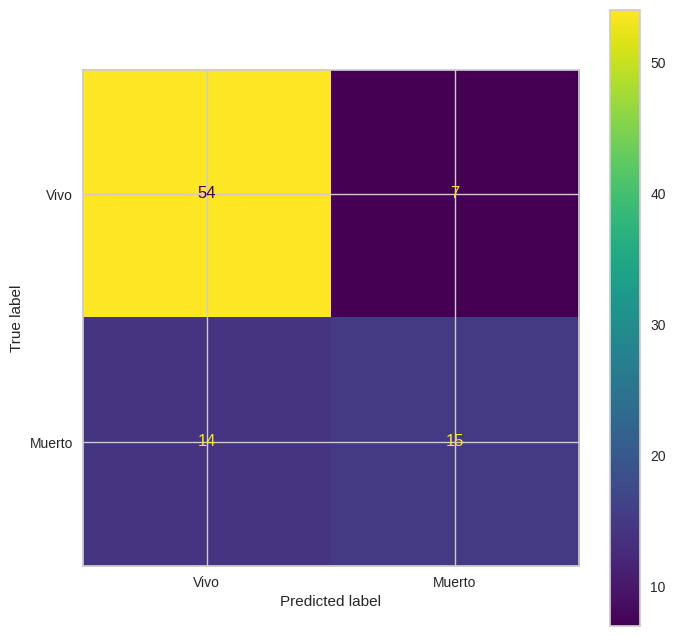

In [21]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(gnb_modelGau, test_varsNormGau,y_testGau, display_labels=['Vivo', 'Muerto'], ax=plt.subplot())

La ligera mejora también se transifere a la matriz de confusión donde la capacidad de predecir que alguien muere ha mejorado con respecto al grupo de variables de antes.

<Figure size 800x800 with 0 Axes>

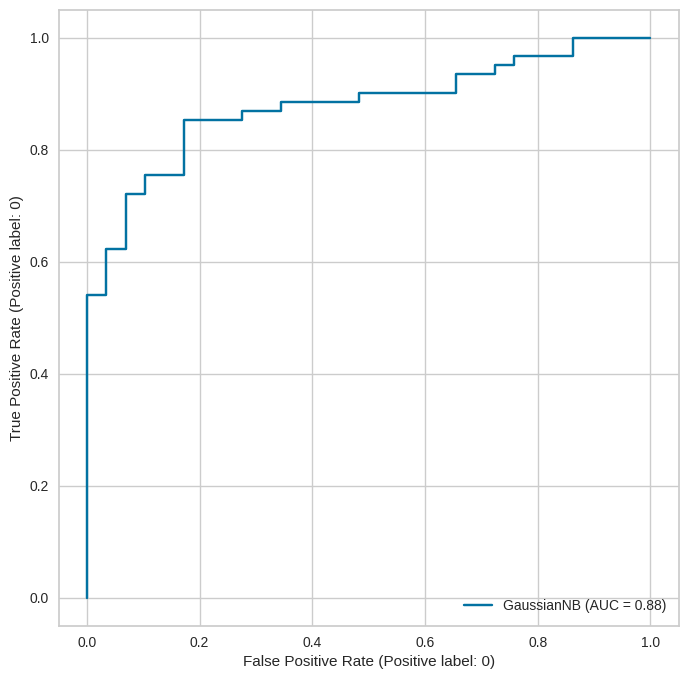

In [22]:
plt.figure(figsize=(8,8))
RocCurveDisplay.from_estimator(gnb_modelGau, test_varsNormGau,y_testGau, pos_label=0, ax=plt.subplot())

Para intentar mejorar el modelo buscaremos el lindar más adecuado. Si vemos la curba, observamos que un valor optimo seria tener un 85% de true positive para un 18% aprox de false positive.

In [23]:
y_prob = gnb_modelGau.predict_proba(test_varsNormGau)[:, 1]

thresholds = np.arange(0, 1.1, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred_thresholded = (y_prob > threshold).astype(int)
    f1_scores.append(f1_score(y_testGau, y_pred_thresholded))
best_threshold = thresholds[np.argmax(f1_scores)]

y_pred_best_threshold = (y_prob > best_threshold).astype(int)

print(f"Encert con lindar {best_threshold}: {accuracy_score(y_testGau, y_pred_best_threshold)}")
print(f"F1-score con lindar {best_threshold}: {f1_score(y_testGau, y_pred_best_threshold)}")
print(f"Precisió con lindar {best_threshold}: {precision_score(y_testGau, y_pred_best_threshold)}")
print(f"Recuperació con lindar {best_threshold}: {recall_score(y_testGau, y_pred_best_threshold)}")

print("F1-score sin lindar:",f1_score(y_testGau, gnb_modelGau.predict(test_varsNormGau), average='weighted'))

Encert con lindar 0.23: 0.8444444444444444
F1-score con lindar 0.23: 0.7741935483870968
Precisió con lindar 0.23: 0.7272727272727273
Recuperació con lindar 0.23: 0.8275862068965517
F1-score sin lindar: 0.7569843441252471


Al contrario que antes, ahora si vemos que con lindar de 0.2 f1-score ha mejorado. Además, si comparamos ambos conjuntos de datos el f1-score anterior es bastante mejor que el primero gracias al ajuste de esas variables que no eran gaussianas obteniendo una mejora considerable.

## Apartado C: LDA

Pese a la mejora obtenida antes al aplicar el logaritmo en algunas variables no gaussianas, seguimos teniendo un margen de mejora amplio, ya que como se ha visto en la matriz de correlación, tenemos variables relacionadas entre ellas. Esto provoca que el modelo pueda desviarse de lo que asume Naive Bayes al asumir que son independientes. Por ese motivo, a continuación, aplicaremos un modelo LDA el cual si tiene en cuenta estas correlaciones y observaremos si se ha mejorado el resultado anterior.   

In [24]:
lda_model = LinearDiscriminantAnalysis().fit(train_varsNorm, y_train)
print(classification_report(lda_model.predict(test_varsNorm), y_test, target_names=['Vivo', 'Muerto']))

results_df = save_results(lda_model, train_varsNorm, y_train, test_varsNorm, y_test, 'LDA', results_df)

              precision    recall  f1-score   support

        Vivo       0.92      0.85      0.88        66
      Muerto       0.66      0.79      0.72        24

    accuracy                           0.83        90
   macro avg       0.79      0.82      0.80        90
weighted avg       0.85      0.83      0.84        90



Con LDA obtenemos mejores valores tanto para precision, recall y f1-score para 'Vivo', pero sobretodo donde esta la mejora es para 'Muerto', ya que antes teniamos valores pésimos. 

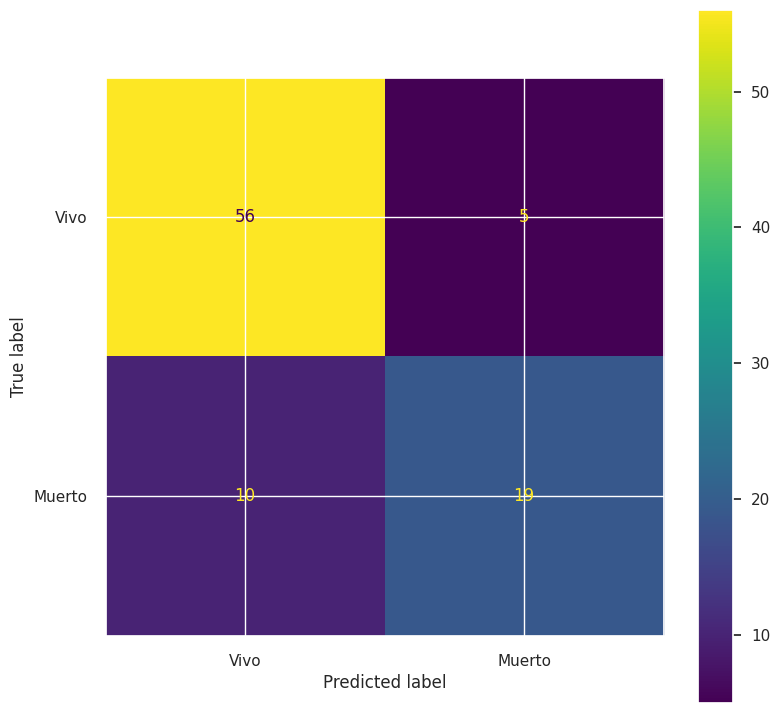

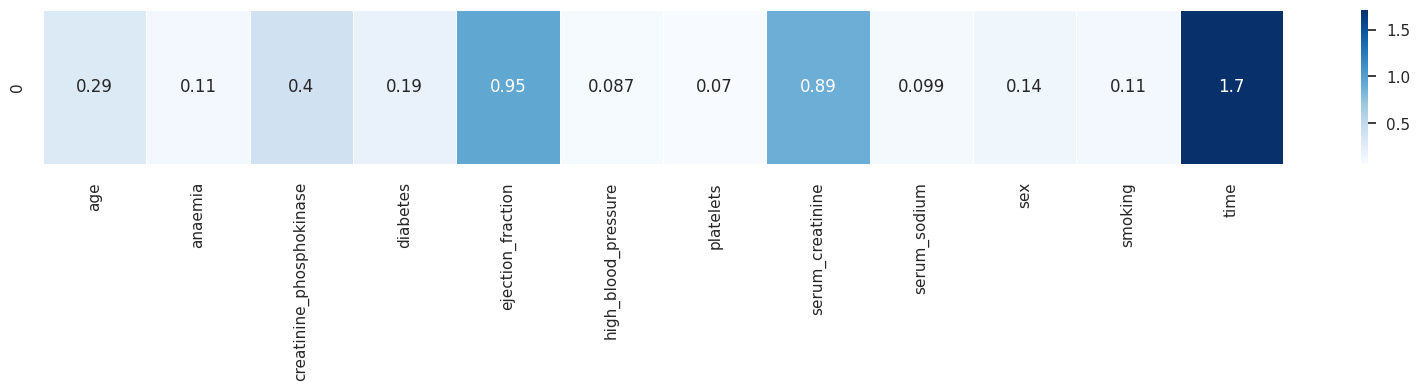

In [25]:
sns.set()
plt.figure(figsize=(9, 9))
ConfusionMatrixDisplay.from_estimator(lda_model, test_varsNorm, y_test, display_labels=['Vivo', 'Muerto'], ax=plt.subplot());
coefs = pd.DataFrame(lda_model.coef_)
coefs.columns = train_varsNorm.columns

plt.figure(figsize=(20,2))
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12})

Para la matriz de confusion obtenemos mejores valores como era de esperarse despues de la mejora de precision, recall y f1-score anterior que para Naive Bayes. Ganamos una mejora substancial donde realmente nos importa que es en los que el modelo predice que van a vivir pero en realidad no, que es el caso que más problemas nos puede traer. 

Y para los coeficientes vemos como "time" tiene una gran importancia como era de esperarse y como se ha explicado anteriormente, ya que cuanto más tiempo se este en observación menos son las posibilidades de pertenecer a la clase 'Muerto'.

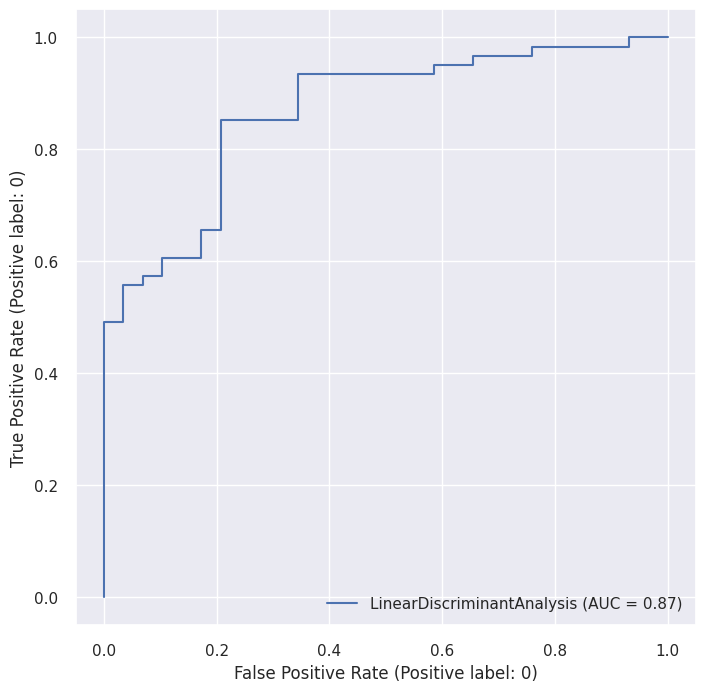

In [26]:
plt.figure(figsize=(8,8))
RocCurveDisplay.from_estimator(lda_model, test_varsNorm, y_test, pos_label=0, ax=plt.subplot())


Para esperar un true positive rate mayor a 90% tendremos un 40%-50% de false positive rate. Si queremos menos false positive rate deberemos sacrificar un poco de true positive rate.

In [27]:
y_prob = lda_model.predict_proba(test_varsNorm)[:, 1]

thresholds = np.arange(0, 1.1, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred_thresholded = (y_prob > threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresholded))
best_threshold = thresholds[np.argmax(f1_scores)]

y_pred_best_threshold = (y_prob > best_threshold).astype(int)

print(f"Encert con lindar {best_threshold}: {accuracy_score(y_test, y_pred_best_threshold)}")
print(f"F1-score con lindar {best_threshold}: {f1_score(y_test, y_pred_best_threshold)}")
print(f"Precisió con lindar {best_threshold}: {precision_score(y_test, y_pred_best_threshold)}")
print(f"Recuperació con lindar {best_threshold}: {recall_score(y_test, y_pred_best_threshold)}")

print("F1-socre sin lindar:", f1_score(y_test, lda_model.predict(test_varsNorm), average='weighted'))

Encert con lindar 0.26: 0.8333333333333334
F1-score con lindar 0.26: 0.7540983606557378
Precisió con lindar 0.26: 0.71875
Recuperació con lindar 0.26: 0.7931034482758621
F1-socre sin lindar: 0.8287525380082207


Respecto a Naive Bayes, vemos una buena mejora que era de esperar por lo mencionado anteriormente y, curiosamente, con un lindar de 0.26 obtenemos peor f1-score que sin él.

## Datos Gaussianos

Para no sonar repetitivo, comentaremos al final un resumen de las diferencias encontradas aplicando el logaritmo a las variables. 

In [28]:
lda_modelGau = LinearDiscriminantAnalysis().fit(train_varsNormGau, y_trainGau)
print(classification_report(lda_modelGau.predict(test_varsNormGau), y_testGau, target_names=['Vivo', 'Muerto']))

results_df = save_results(lda_modelGau, train_varsNormGau, y_trainGau, test_varsNormGau, y_testGau, 'LDA Gauss', results_df)

              precision    recall  f1-score   support

        Vivo       0.95      0.82      0.88        71
      Muerto       0.55      0.84      0.67        19

    accuracy                           0.82        90
   macro avg       0.75      0.83      0.77        90
weighted avg       0.87      0.82      0.83        90



<Figure size 900x900 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Axes: >

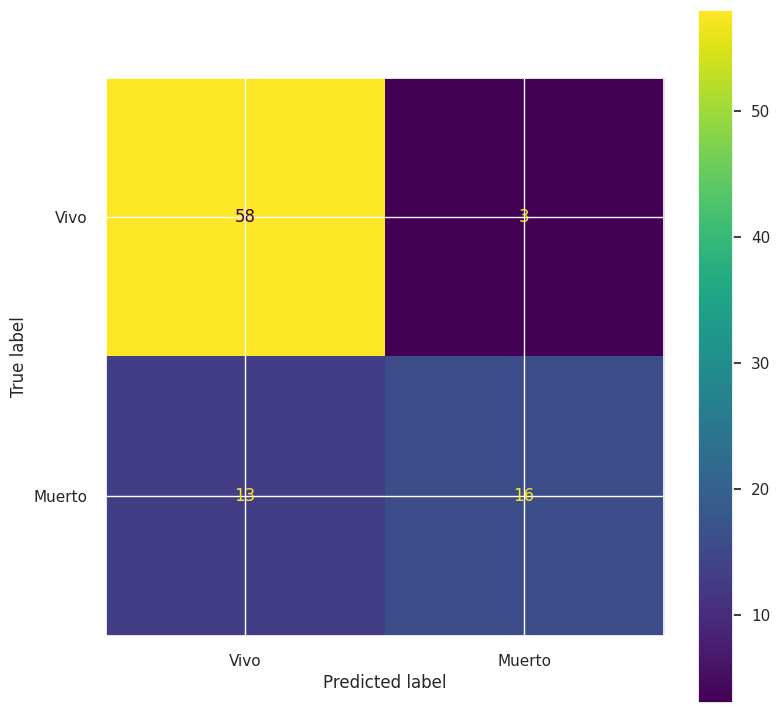

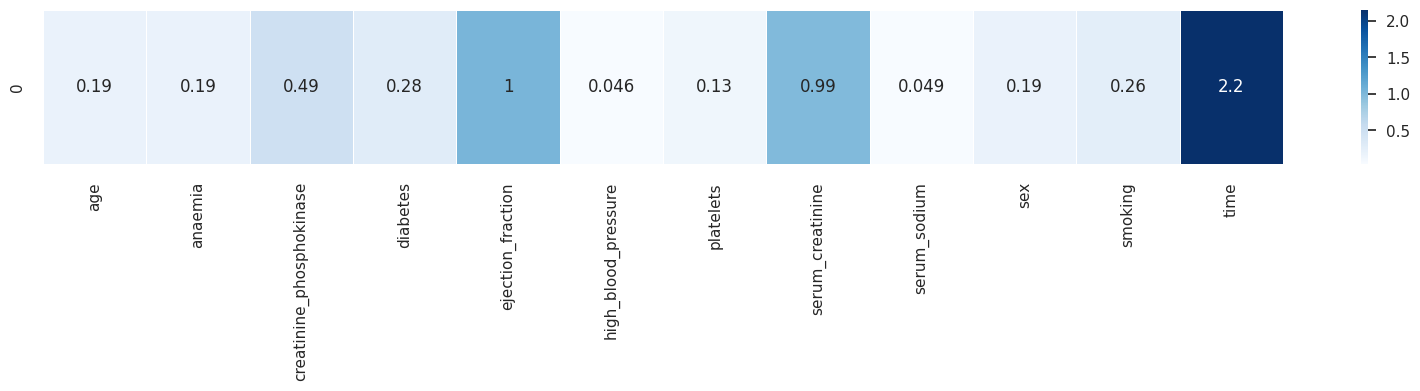

In [29]:
sns.set()
plt.figure(figsize=(9, 9))
ConfusionMatrixDisplay.from_estimator(lda_modelGau, test_varsNormGau, y_testGau, display_labels=['Vivo', 'Muerto'], ax=plt.subplot())
coefs = pd.DataFrame(lda_modelGau.coef_)
coefs.columns = train_varsNormGau.columns

plt.figure(figsize=(20,2))
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12})

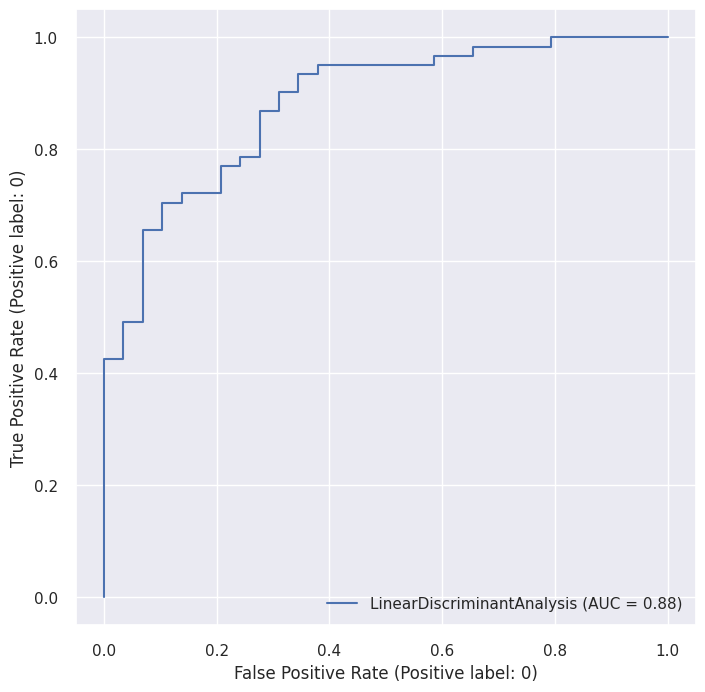

In [30]:
plt.figure(figsize=(8,8))
RocCurveDisplay.from_estimator(lda_modelGau, test_varsNormGau, y_testGau, pos_label=0, ax=plt.subplot())

In [31]:
y_prob = lda_modelGau.predict_proba(test_varsNormGau)[:, 1]

thresholds = np.arange(0, 1.1, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred_thresholded = (y_prob > threshold).astype(int)
    f1_scores.append(f1_score(y_testGau, y_pred_thresholded))
best_threshold = thresholds[np.argmax(f1_scores)]

y_pred_best_threshold = (y_prob > best_threshold).astype(int)

print(f"Encert con lindar {best_threshold}: {accuracy_score(y_testGau, y_pred_best_threshold)}")
print(f"F1-score con lindar {best_threshold}: {f1_score(y_testGau, y_pred_best_threshold)}")
print(f"Precisió con lindar {best_threshold}: {precision_score(y_testGau, y_pred_best_threshold)}")
print(f"Recuperació con lindar {best_threshold}: {recall_score(y_testGau, y_pred_best_threshold)}")

print("F1-score:", f1_score(y_testGau, lda_modelGau.predict(test_varsNormGau), average='weighted'))

Encert con lindar 0.34: 0.8444444444444444
F1-score con lindar 0.34: 0.7307692307692308
Precisió con lindar 0.34: 0.8260869565217391
Recuperació con lindar 0.34: 0.6551724137931034
F1-score: 0.8104377104377104


Si le aplicamos la transformación logaritmica a los datos, visulizamos un empeoramiento en el f1-score, más concretamente vemos como la precisión aumenta, pero el recall baja considerablemente (lo cual se traduce en la matriz de confusion). En este apartado, no es necesario aplicar ningun lindar porque tambien empeora el resultado. Además, "time" sigue siendo el coeficiente con mayor peso para indicar a que clase pertenece nuestra variable objetivo.

## Apartado D: Regresión Logística

Como hay una mezcla de variables discretas y continuas en nuestro conjunto de datos, aplicaremos un modelo de regresión logísitca para ver si mejora los resultados obtenidos de los modelos anteiores. 

In [32]:
lr_model = LogisticRegression(max_iter=10000)
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr_model,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(train_varsNorm, y_train)
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                         'penalty': ['l1', 'l2']})

,params,mean_test_score,rank_test_score
17,"{'C': 0.25118864315095796, 'penalty': 'l2'}",0.833095,1
15,"{'C': 0.12589254117941676, 'penalty': 'l2'}",0.833095,1
13,"{'C': 0.0630957344480193, 'penalty': 'l2'}",0.828333,3
23,"{'C': 1.9952623149688788, 'penalty': 'l2'}",0.823333,4
29,"{'C': 15.848931924611142, 'penalty': 'l2'}",0.823333,4


Con la función GridSearch encontraremos los mejores parametros para el modelo. Estos son : C = 0.251 y penalty = l2.

<Figure size 2000x200 with 0 Axes>

<Axes: >

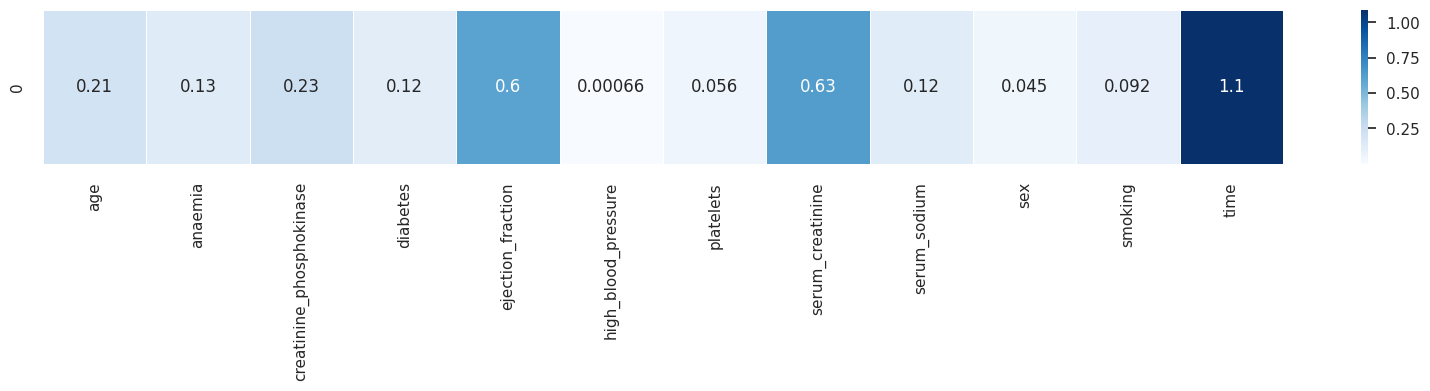

In [33]:
coefs = pd.DataFrame(lr_gs.best_estimator_.coef_)
coefs.columns = train_varsNorm.columns

plt.figure(figsize=(20,2))
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12})

              precision    recall  f1-score   support

        Vivo       0.93      0.84      0.88        68
      Muerto       0.62      0.82      0.71        22

    accuracy                           0.83        90
   macro avg       0.78      0.83      0.79        90
weighted avg       0.86      0.83      0.84        90



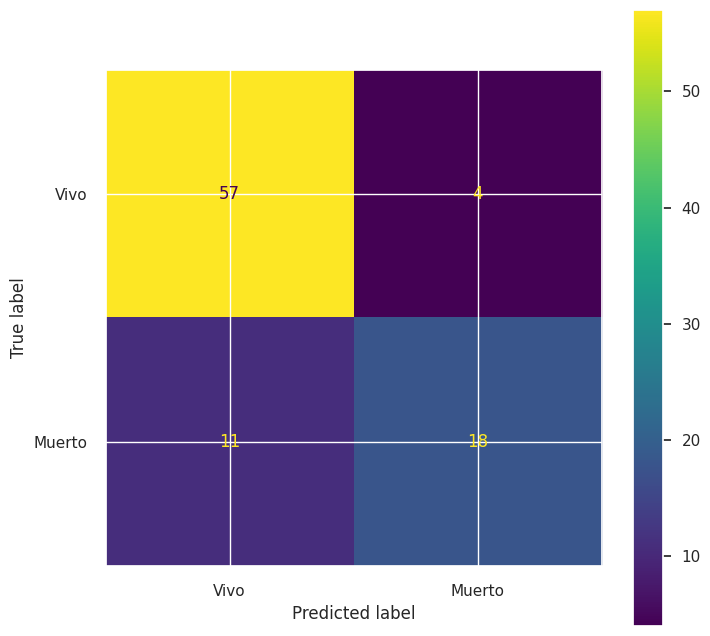

In [34]:
print(classification_report(lr_gs.predict(test_varsNorm), y_test, target_names=['Vivo', 'Muerto']))
results_df = save_results(lr_gs, train_varsNorm, y_train, test_varsNorm, y_test, 'Logistic UnBalanced', results_df)

plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(lr_gs, test_varsNorm,y_test, display_labels=['Vivo', 'Muerto'], ax=plt.subplot())

Si comparamos con modelos anteriores existe una mejora en los resultados obtenidos pero nada fuera de lo normal. De hecho, LDA sigue teniendo ciertos valores mejores que para este modelo. Debemos seguir explorando para llegar a más conclusiones

<Figure size 800x800 with 0 Axes>

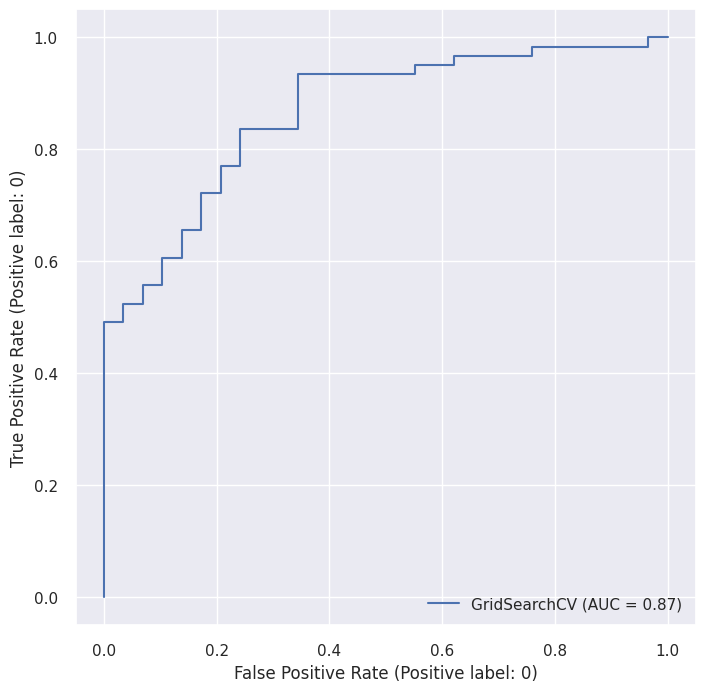

In [35]:
plt.figure(figsize=(8,8))
RocCurveDisplay.from_estimator(lr_gs, test_varsNorm,y_test, pos_label=0, ax=plt.subplot())

In [36]:
y_prob = lr_gs.predict_proba(test_varsNorm)[:, 1]

thresholds = np.arange(0, 1.1, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred_thresholded = (y_prob > threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresholded))
best_threshold = thresholds[np.argmax(f1_scores)]

y_pred_best_threshold = (y_prob > best_threshold).astype(int)

print(f"Encert con lindar {best_threshold}: {accuracy_score(y_test, y_pred_best_threshold)}")
print(f"F1-score con lindar {best_threshold}: {f1_score(y_test, y_pred_best_threshold)}")
print(f"Precisió con lindar {best_threshold}: {precision_score(y_test, y_pred_best_threshold)}")
print(f"Recuperació con lindar {best_threshold}: {recall_score(y_test, y_pred_best_threshold)}")

print("F1-score:", f1_score(y_test, lr_gs.predict(test_varsNorm), average='weighted'))

Encert con lindar 0.46: 0.8444444444444444
F1-score con lindar 0.46: 0.7307692307692308
Precisió con lindar 0.46: 0.8260869565217391
Recuperació con lindar 0.46: 0.6551724137931034
F1-score: 0.8264173886608908


Los resultados obtenidos para esta regresión logísitca para las variables sin aplicar logaritmo es peor que para LDA. Además tampoco existe ningun lindar que mejore los resultados del modelo.

### Datos Gaussianos

In [37]:
lr_model = LogisticRegression(max_iter=10000)
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr_model,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(train_varsNormGau, y_trainGau)
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                         'penalty': ['l1', 'l2']})

,params,mean_test_score,rank_test_score
17,"{'C': 0.25118864315095796, 'penalty': 'l2'}",0.852143,1
41,"{'C': 1000.0, 'penalty': 'l2'}",0.851905,2
23,"{'C': 1.9952623149688788, 'penalty': 'l2'}",0.851905,2
29,"{'C': 15.848931924611142, 'penalty': 'l2'}",0.851905,2
21,"{'C': 1.0, 'penalty': 'l2'}",0.851905,2


Los mejores valores para los parametros siguen siendo los mismos.

<Figure size 2000x200 with 0 Axes>

<Axes: >

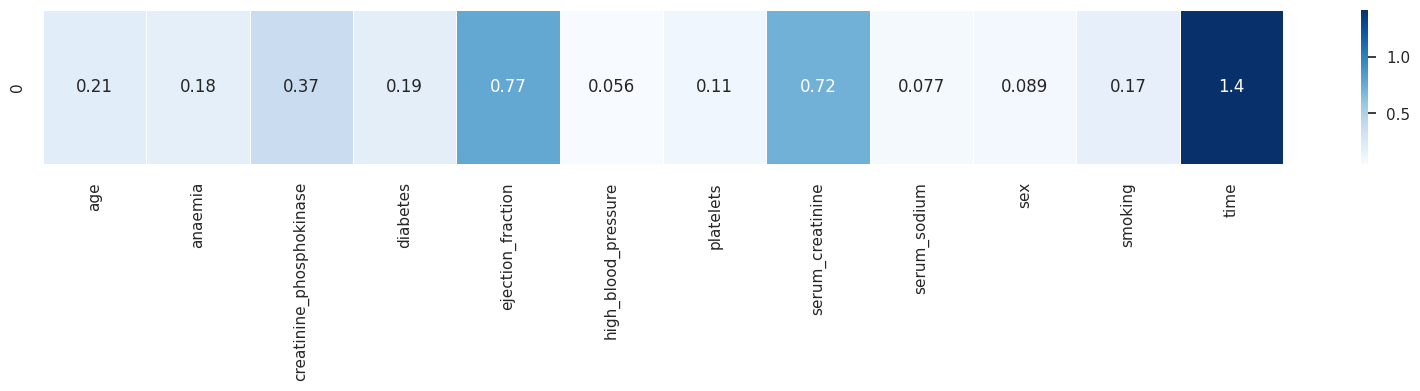

In [38]:
coefs = pd.DataFrame(lr_gs.best_estimator_.coef_)
coefs.columns = train_varsNormGau.columns

plt.figure(figsize=(20,2))
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12})

              precision    recall  f1-score   support

        Vivo       0.95      0.81      0.87        72
      Muerto       0.52      0.83      0.64        18

    accuracy                           0.81        90
   macro avg       0.73      0.82      0.76        90
weighted avg       0.86      0.81      0.83        90



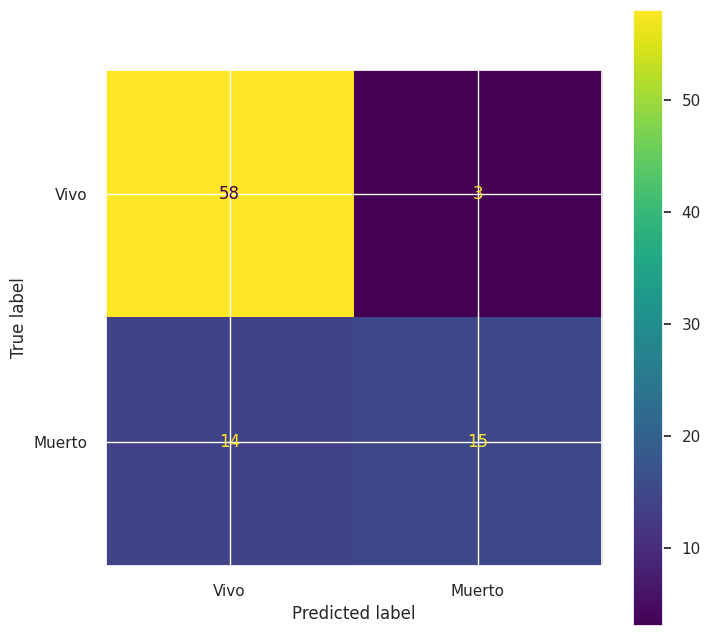

In [39]:
print(classification_report(lr_gs.predict(test_varsNormGau), y_testGau, target_names=['Vivo', 'Muerto']))
results_df = save_results(lr_gs, train_varsNormGau, y_trainGau, test_varsNormGau, y_testGau, 'Logistic UnBalanced Gauss', results_df)

plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(lr_gs, test_varsNormGau,y_testGau, display_labels=['Vivo', 'Muerto'], ax=plt.subplot())

Ahora podemos ver como ha empeorado la capacidad del modelo de predecir 'Muerto', lo cual es preocupante por lo que se ha comentado anteriormente del problema que se genera al predecir que alguien va a vivir pero realmente no.

<Figure size 800x800 with 0 Axes>

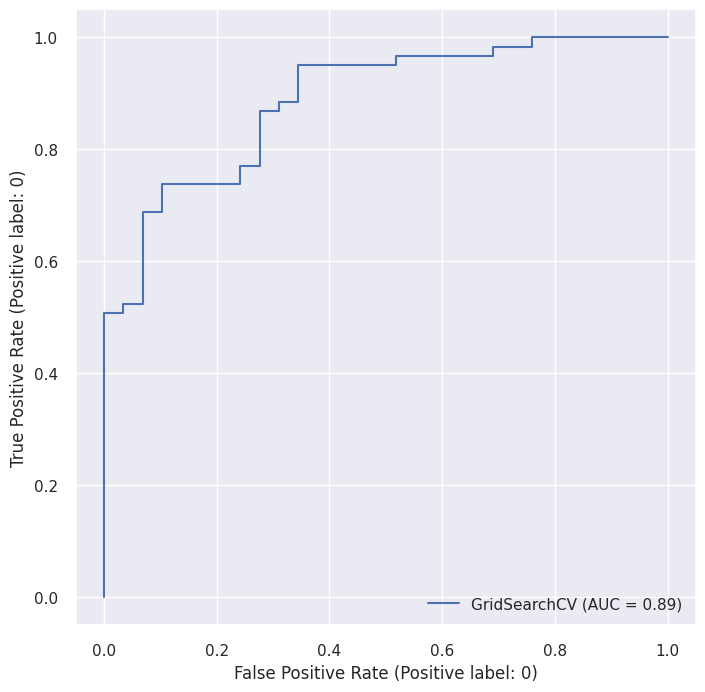

In [40]:
plt.figure(figsize=(8,8))
RocCurveDisplay.from_estimator(lr_gs, test_varsNormGau,y_testGau, pos_label=0, ax=plt.subplot())

In [41]:
y_prob = lr_gs.predict_proba(test_varsNormGau)[:, 1]

thresholds = np.arange(0, 1.1, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred_thresholded = (y_prob > threshold).astype(int)
    f1_scores.append(f1_score(y_testGau, y_pred_thresholded))
best_threshold = thresholds[np.argmax(f1_scores)]

y_pred_best_threshold = (y_prob > best_threshold).astype(int)

print(f"Encert con lindar {best_threshold}: {accuracy_score(y_testGau, y_pred_best_threshold)}")
print(f"F1-score con lindar {best_threshold}: {f1_score(y_testGau, y_pred_best_threshold)}")
print(f"Precisió con lindar {best_threshold}: {precision_score(y_testGau, y_pred_best_threshold)}")
print(f"Recuperació con lindar {best_threshold}: {recall_score(y_testGau, y_pred_best_threshold)}")

print("F1-score:", f1_score(y_testGau, lr_gs.predict(test_varsNormGau), average='weighted'))

Encert con lindar 0.42: 0.8555555555555555
F1-score con lindar 0.42: 0.7450980392156864
Precisió con lindar 0.42: 0.8636363636363636
Recuperació con lindar 0.42: 0.6551724137931034
F1-score: 0.7968182868518814


Los resultados obtenidos son muy parecidos al grupo de datos sin aplicar logaritmo y un poco peores que para los del modelo LDA.

## Clases Balanceadas

A continuación, se probara el parametro 'balanced', ya que las clases no están balanceadas. No se repetira todo los gráficos intermedios para no ser repetitivos y solo analizaremos los valores de precision, recall y f1-score.

In [42]:

lr_model = LogisticRegression(max_iter=10000, class_weight='balanced')
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr_model,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(train_varsNorm, y_train)
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

results_df = save_results(lr_gs, train_varsNorm, y_train, test_varsNorm, y_test, 'Logistic Balanced', results_df)

GridSearchCV(cv=10,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                         'penalty': ['l1', 'l2']})

,params,mean_test_score,rank_test_score
13,"{'C': 0.0630957344480193, 'penalty': 'l2'}",0.799524,1
1,"{'C': 0.001, 'penalty': 'l2'}",0.799524,2
3,"{'C': 0.001995262314968879, 'penalty': 'l2'}",0.799524,2
5,"{'C': 0.003981071705534973, 'penalty': 'l2'}",0.799524,2
7,"{'C': 0.007943282347242814, 'penalty': 'l2'}",0.799524,2


Ahora los mejores valores son: C = 0.063 y penalty = l2.

In [43]:
y_prob = lr_gs.predict_proba(test_varsNorm)[:, 1]

thresholds = np.arange(0, 1.1, 0.1)
f1_scores = []

for threshold in thresholds:
    y_pred_thresholded = (y_prob > threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresholded))
best_threshold = thresholds[np.argmax(f1_scores)]

y_pred_best_threshold = (y_prob > best_threshold).astype(int)

print(f"Encert con lindar {best_threshold}: {accuracy_score(y_test, y_pred_best_threshold)}")
print(f"F1-score con lindar {best_threshold}: {f1_score(y_test, y_pred_best_threshold)}")
print(f"Precisió con lindar {best_threshold}: {precision_score(y_test, y_pred_best_threshold)}")
print(f"Recuperació con lindar {best_threshold}: {recall_score(y_test, y_pred_best_threshold)}")

print("F1-score:", f1_score(y_test, lr_gs.predict(test_varsNorm), average='weighted'))

Encert con lindar 0.6000000000000001: 0.8333333333333334
F1-score con lindar 0.6000000000000001: 0.7169811320754716
Precisió con lindar 0.6000000000000001: 0.7916666666666666
Recuperació con lindar 0.6000000000000001: 0.6551724137931034
F1-score: 0.8016666666666667


Los resultados siguen siendo muy parecidos a los modelos anteriores y no obtenemos mejoras significativas.

### Datos Gaussianos

In [44]:
lr_model = LogisticRegression(max_iter=10000, class_weight='balanced')
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr_model,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(train_varsNormGau, y_trainGau)
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

results_df = save_results(lr_gs, train_varsNormGau, y_trainGau, test_varsNormGau, y_testGau, 'Logistic Balanced Gauss', results_df)

GridSearchCV(cv=10,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                         'penalty': ['l1', 'l2']})

,params,mean_test_score,rank_test_score
5,"{'C': 0.003981071705534973, 'penalty': 'l2'}",0.847143,1
7,"{'C': 0.007943282347242814, 'penalty': 'l2'}",0.847143,1
13,"{'C': 0.0630957344480193, 'penalty': 'l2'}",0.837619,3
1,"{'C': 0.001, 'penalty': 'l2'}",0.837619,3
3,"{'C': 0.001995262314968879, 'penalty': 'l2'}",0.837619,3


Ahora los mejores valores son: C = 0.0398 y penalty = l2.

In [45]:
y_prob = lr_gs.predict_proba(test_varsNormGau)[:, 1]

thresholds = np.arange(0, 1.1, 0.1)
f1_scores = []

for threshold in thresholds:
    y_pred_thresholded = (y_prob > threshold).astype(int)
    f1_scores.append(f1_score(y_testGau, y_pred_thresholded))
best_threshold = thresholds[np.argmax(f1_scores)]

y_pred_best_threshold = (y_prob > best_threshold).astype(int)

print(f"Encert con lindar {best_threshold}: {accuracy_score(y_testGau, y_pred_best_threshold)}")
print(f"F1-score con lindar {best_threshold}: {f1_score(y_testGau, y_pred_best_threshold)}")
print(f"Precisió con lindar {best_threshold}: {precision_score(y_testGau, y_pred_best_threshold)}")
print(f"Recuperació con lindar {best_threshold}: {recall_score(y_testGau, y_pred_best_threshold)}")

print("F1-score:", f1_score(y_testGau, lr_gs.predict(test_varsNormGau), average='weighted'))

Encert con lindar 0.5: 0.8111111111111111
F1-score con lindar 0.5: 0.711864406779661
Precisió con lindar 0.5: 0.7
Recuperació con lindar 0.5: 0.7241379310344828
F1-score: 0.8119313318080652


Los resultados siguen siendo muy parecidos a los modelos anteriores y no obtenemos mejoras significativas.

## Resultados Obtenidos

In [46]:
results_df

,train acc,test acc,precision score (W),recall score (W),f1 score (W)
Naive Bayes,0.761429,0.733333,0.719002,0.733333,0.715657
Naive Bayes Gauss,0.838095,0.766667,0.757932,0.766667,0.756984
LDA,0.832857,0.833333,0.830177,0.833333,0.828753
LDA Gauss,0.842381,0.822222,0.825023,0.822222,0.810438
Logistic UnBalanced,0.837857,0.833333,0.831774,0.833333,0.826417
Logistic UnBalanced Gauss,0.842381,0.811111,0.814506,0.811111,0.796818
Logistic Balanced,0.799524,0.800000,0.804155,0.800000,0.801667
Logistic Balanced Gauss,0.828095,0.811111,0.812963,0.811111,0.811931


Una vez probado todos los modelos con los conjuntos de datos, podemos ver como el peor de todos es Naive Bayes por lo que ya se ha comentado que asume la independencia de las variables cuando no es así. Los otros modelos obtienen resultados similares. Si tuvieramos que escoger uno fijandonos en la precision, el recall y f1-score sería LDA. Aunque Logistic UnBalanced tambien es un modelo que lo haría bien. 